In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            print(i)
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
            # print(F"{row['head']}: {row['age']:.4f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
# found_cards = pd.DataFrame(cards, columns=['head', 'body'])
# found_cards['hash'] = found_cards['body'].apply(hash_string_md5)

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * 1.05
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')
cards_to_age.to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats

,age_sum,age_mean,head_count
head,,,
OData Requests,51.940151,51.940151,1
Jane Eyre,142.341818,14.234182,10
General,171.836892,42.959223,4
Developer Mode,176.584637,44.146159,4
Azure VDI Project,212.797782,42.559556,5
Dataverse Plugins,221.060732,31.580105,7
Diffusers Documentation,224.088855,44.817771,5
AKS,225.049092,28.131136,8
Dataverse,225.823670,45.164734,5


<Axes: >

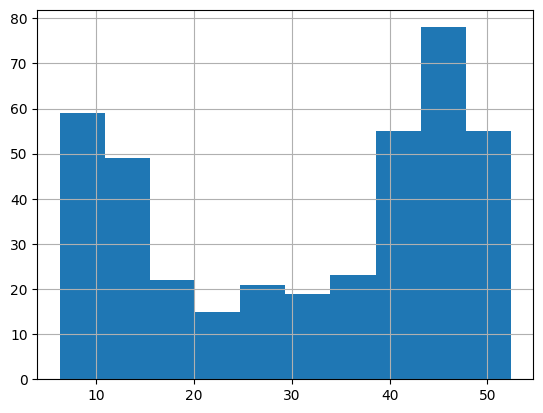

In [22]:
existing_cards['age'].hist()

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)

# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Shuffle

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [25]:
existing_cards[['head', 'age']].head(n = 10)

,head,age
0,Diffusers Library,48.121563
1,Diffusers Library,47.302398
2,Diffusers Library,47.577584
3,Diffusers Library,47.106308
4,Diffusers Library,47.164885
5,Diffusers Library,46.764721
6,Diffusers Library,45.629999
7,Diffusers Library,45.436269
8,Diffusers Library,44.943630
9,Diffusers Library,43.666387


# Headers with fewest notes first

In [26]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['oldest'] *= -1

existing_cards.sort_values(['frequency', 'oldest', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
existing_cards['head'].value_counts()

head
Home Network Project              44
DNS                               36
Azure Kubernetes Learning Path    34
Python                            26
Search Engine Optimization        25
sklearn                           21
Diffusers Library                 21
Azure Functions                   19
OData                             17
Power BI                          12
MS Identity Platform              11
PP365                             10
Kali Linux                        10
Jane Eyre                         10
Diffusers from Hugging Face       10
Dataverse Queries                  8
AKS                                8
Azure AI Search                    7
Dataverse Plugins                  7
Conditional Access                 7
pandas                             6
Azure OpenAI                       6
Git                                6
Workera.ai                         6
Azure VDI Project                  5
Azure Storage                      5
Diffusers Documentation          

# Focus on one header

In [28]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# one_header = 'Diffusers Library'
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

In [30]:
existing_cards

,head,body,hash,age,frequency,oldest
395,OData Requests,Deserialization in APIs:\nThe process of conve...,04ae55826e9671a39359368f13ae7a88,51.940151,1,-51.940151
380,Developer Mode,"When you enable Developer Mode on desktop, a p...",e290583d4b0a288a9b8a9eac8593a50f,42.043935,4,-46.294899
379,Developer Mode,Developer Mode replaces the Windows 8.1 requir...,d8cc89cee1c33af43b431eca3e19469a,42.651896,4,-46.294899
378,Developer Mode,The Windows App SDK was previously known by th...,2b62fe83c4968df62cc43574bf50e349,45.593907,4,-46.294899
377,Developer Mode,The Windows SDK provides access to all of the ...,15f44fc8521cd9dcc4483ce56f3a6232,46.294899,4,-46.294899
...,...,...,...,...,...,...
221,Home Network Project,Front: What is SELinux and how does it enhance...,56b104b58f229d26a5a25a90eb2ad290,10.373013,44,-11.281723
217,Home Network Project,Front: What is Network Latency and how can it ...,bd0bb233271b734d83628f3d11673db1,10.473457,44,-11.281723
216,Home Network Project,Front: What is pfSense and what are its primar...,169c3e29c039fb43cedc819649bf1dac,10.685856,44,-11.281723
218,Home Network Project,Front: Define SSL/TLS Handshake.\n\nBack: The ...,fca0eb85082a856df62a05474dba2617,10.758604,44,-11.281723


In [31]:
15.6e3/641*30/100

7.301092043681747